# **Methylation Biomarkers for Predicting Cancer**

## **Dimensionality Reduction: Principal Component Anlaysis**

**Author:** Meg Hutch

**Date:** February 09, 2020

**Objective:** Reduce dimensionality of the gene methylation data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

Load Training and testing sets processed in R

In [2]:
# Training set
mcTrain = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTrain_70_30.csv')
# Testing set
mcTest = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTest_70_30.csv')

**Data Pre-Processing**

Check if any missing values: Nope!

In [3]:
mcTest.columns[mcTest.isna().any()].tolist()
mcTrain.columns[mcTest.isna().any()].tolist()

[]

## **Principal Component Analysis**

We will first conduct dimensionality reduction using principal component analysis

First, subset the training set to only include the methylated gene information

In [4]:
# remove non-gene data from both the training and testing sets
genesTrain = mcTrain.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender", "frag_mean"])
genesTest = mcTest.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender", "frag_mean"])

Create patient seq_num id index

In [5]:
## Training set
# Convert patinet_ids to row names 
genesTrain = genesTrain.set_index(genesTrain.seq_num)

# Remove seq_num as a column
genesTrain = genesTrain.drop(columns=["seq_num"])

# Create a list of row names
patients = list(genesTrain.index)

## Testing set
# Convert patinet_ids to row names 
genesTest = genesTest.set_index(genesTest.seq_num)

# Remove seq_num as a column
genesTest = genesTest.drop(columns=["seq_num"])

# Create a list of row names
patientsTest = list(genesTest.index)

# **1) Standardize Dataset**

We will scale the data prior to performing PCA on the training set. 

**StandardScaler** helps standardize features onto unit scale (mean = 0 and standard deviation = 1). Thus, each value in the dataset will have the sample mean value subtracted and then divided by the standard deviation of the whole dataset. 


In [6]:
# pca packages
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

# Stanardize/Scale the data
x = StandardScaler().fit_transform(genesTrain.astype(np.float)) # no errors  

In [7]:
# manual check that the StandardScaler().fit_transform is correctly scaling the data - look good
#genesTrain.head()
#np.mean(genesTrain['OR4F5'])
#np.std(genesTrain['OR4F5'])

#np.mean(genesTrain['AL627309.1'])
#np.std(genesTrain['AL627309.1'])

**Check whether the normalized data has a mean of zero and a standard deviation of 1:**

In [8]:
np.mean(x), np.std(x)

(-6.118212297878064e-19, 0.9612655271113001)

**Standardize the Test Set**

To standardize each column of the test set, we need to subtract the mean of the training data and then divide by the standard deviation of the training data.

In [9]:
# Functions to calculate mean and sd of each column 
genesTrain_mean = genesTrain.mean()
genesTrain_sd = genesTrain.std()

Transpose the mean and sd datasets in order to faciliate the calculations with the testing sets

In [10]:
# Transpose the mean dataset
genesTrain_mean = pd.DataFrame(genesTrain_mean)
genesTrain_mean = genesTrain_mean.transpose()

# add duplicated rows to match the number of rows in the test set (100 samples) - this will faciliate the subtraction and standard deviation division
genesTrain_mean = pd.concat([genesTrain_mean]*100)

# Transpose the sd dataset
genesTrain_sd = pd.DataFrame(genesTrain_sd)
genesTrain_sd = genesTrain_sd.transpose()
# add duplicated rows to match the number of rows in the test set

# Add duplicated rows to the sd dataset
genesTrain_sd = pd.concat([genesTrain_sd]*100)

In [11]:
# remove index
genesTest.reset_index(level=0, inplace=True)
# Drop seq_num column
genesTest = genesTest.drop(columns=["seq_num"])

**Replace 0s with 0.01 in order to not get NA values - is this koshure?**

In [12]:
genesTrain_sd = genesTrain_sd.replace(0, 0.0000000001)

**Subtract each value in the Test set by the training set mean and divide by the training set standard deviation**

In [13]:
# Subtract the mean values from the genesTest
genesTest = pd.DataFrame(genesTest.values-genesTrain_mean.values, columns=genesTest.columns)

# Divide the trained mean subtracted values by standard deviation of the training set
genesTest = pd.DataFrame(genesTest.values/genesTrain_sd.values, columns=genesTest.columns)

**Remove any genes that have NAs**

Because we converted 0s to NA, none of these are NAs

In [14]:
genesTest = genesTest.dropna(axis = 1) # by indicating axis = 1, we are able to drop any genes that have become NAs === are we still have to perform PCA now? 

**Convert the normalized features into tabular format**

In [15]:
# Create list of column names
features = list(genesTrain.columns.values) 

# Create data frame of newly normalized data - use patients IDs as the index 
x = pd.DataFrame(x, columns = features, index = patients)

# **2) Determine Prinicpal Components**

Reference: https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

**pca.fit** allows PCA function to compute vectors that you can project your data onto in order to reduce the dimensionality of your data.

**pca.transform** actually performs the projection. It projects each row of data into the vector space that was learned when fit was called.

from sklearn: **fit_transform**: Fit the model with X and apply the dimensionality reduction on X

In [16]:
## Define pca function
pca = PCA()

# Fit to the scaled/standardized data - then use transform to prokect into the new vector space learned by fit
principalComponents = pca.fit_transform(x)

# Generate a list of column names with the number for each prinicpal component 
col_names = [f'pc{i}' for i in range(1, 243)] # there are 242 samples - so we want to have range of 1 less than 243 column names 

# Add column names to the principal component dataset 
principalDf_ALL = pd.DataFrame(principalComponents, columns = col_names, index = patients)

**3) Determine # of Components and Variance**

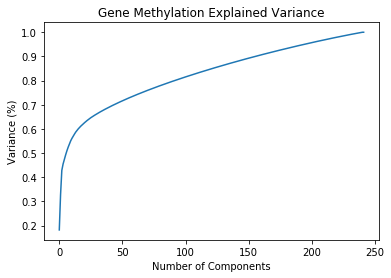

In [17]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Gene Methylation Explained Variance')
plt.savefig('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/04_Results/Component_%Variance.png')
plt.show()

**Alternative method - Pre-selecting % of variance**

When we fit the PCA classifier and transform x after specifying 90%, we get 157 principal components representing 90% of the variance.

In [18]:
pca = PCA(0.9)
genesTrain_transformed = pca.fit_transform(x)

pca.n_components_ 

157

**Define PC column names and create dataframe**

In [19]:
# Define new pc column names (up to pc157)
col_names = [f'pc{i}' for i in range(1, 158)] 

# Add column names to the principal component dataset 
genesTrain_transformed = pd.DataFrame(genesTrain_transformed, columns = col_names, index = patients)

**Scree Plot**

View which principal components contribute most to the variance 

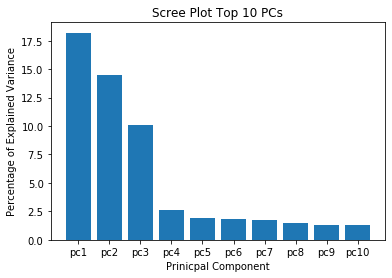

In [20]:
# remove PC from 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[:10] #top 10 PC - this number is chosen just so that we can more easily view the plot
labels = col_names[:10]

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Prinicpal Component')
plt.title('Scree Plot Top 10 PCs')
plt.savefig('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/04_Results/PCA_Screeplot.png')
plt.show()

# **4) Project prinicipal components onto the test set**

In [21]:
genesTest_transformed = pca.transform(genesTest)

When converted to a dataframe, we can see that the test set has been transformed into 157 principal components

In [22]:
genesTest_transformed = pd.DataFrame(data = genesTest_transformed, columns = col_names, index = patientsTest)
genesTest_transformed

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc148,pc149,pc150,pc151,pc152,pc153,pc154,pc155,pc156,pc157
SEQF2031,25.714432,35.710609,8.660117,-28.300248,-3.458172,12.234590,21.866102,-2.740614,1.943432,0.701033,...,-0.109039,0.286528,-0.195140,0.406345,-0.602839,-0.572926,-0.632002,-0.348959,0.006663,0.020318
SEQF2033,-31.700184,41.220510,-16.317049,-22.816744,-19.153017,2.487309,17.125982,-8.879650,-1.352012,-11.923261,...,0.310881,-0.516501,-0.051782,2.154218,0.416111,0.088807,-0.020113,-0.026909,-0.265730,0.530086
SEQF2044,-48.634885,29.426229,0.047433,-12.224692,13.754511,-7.610225,-11.053351,6.226145,2.015875,7.793647,...,1.477525,1.068487,0.590879,0.142299,0.339313,-0.141077,-0.580471,-0.321441,0.451757,-0.779605
SEQF2045,36.682052,-16.154398,-33.762601,5.008985,-17.637626,-2.446388,9.280561,-9.971157,-2.568443,-12.136507,...,0.833511,-1.416354,-0.644939,-0.103568,0.991806,1.648487,0.965989,-0.534218,-0.756069,-0.125104
SEQF2048,4.461318,1.075068,15.480212,-18.559789,-7.292509,10.038602,9.029338,-2.489100,-1.157113,-0.386717,...,-1.174886,-0.216253,-0.915484,-0.534768,-0.132050,-0.259549,-0.235714,-0.690764,-0.976456,-0.469155
SEQF2132,-21.221194,-7.205681,18.793754,19.231603,-18.252462,27.934587,3.397386,-3.779976,-1.040603,-9.385515,...,0.546008,1.484901,-0.527382,0.768585,0.926111,0.568163,0.685694,-0.305338,-0.751001,1.108734
SEQF2138,-19.279633,-12.488597,9.564614,-12.675370,-7.248269,8.575875,14.607355,-3.341069,0.820051,-1.328676,...,0.600376,0.986227,0.528053,-0.560324,0.834046,-0.351954,0.881775,0.085300,-0.564539,0.949586
SEQF2147,2.732246,-47.669587,-7.818755,-18.694945,1.897661,13.898341,8.227444,-0.068972,0.331242,4.642527,...,1.052124,-1.287801,0.490595,-0.831172,-0.714629,-0.111670,0.566369,-0.820433,0.072339,-0.250865
SEQF2152,-31.184431,-29.366058,-3.528788,-6.787261,-15.668441,13.060293,11.566880,-5.429243,-2.686812,-7.019299,...,0.876259,-0.527193,0.003799,-0.486647,0.344149,0.405499,-0.778299,0.096939,-0.481207,0.592713
SEQF2155,-10.544593,-31.814553,7.583557,-9.962724,-21.890076,-1.721119,13.549452,-10.621239,-4.399704,-14.367942,...,-0.664679,0.723579,0.259830,3.204669,0.336520,-0.389941,1.405023,-0.244940,-1.031531,0.446619


# **5) Save PCA Components**

In [25]:
#principalDf_ALL.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/principalDF_ALL.csv')
#genesTrain_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTrain_transformed_157pc_70_30.csv')
#genesTest_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTest_transformed_157pc_70_30.csv')

genesTrain_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/Final_Datasets/genesTrain_Full_70_30.csv')
genesTest_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/Final_Datasets/genesTest_Full_70_30.csv')